### Imports

In [56]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as r2

%matplotlib inline

### Data

In [38]:
def get_data(f_name):
    #fname = "A1Benchmark/real_1.csv"
    path = "../data/ydata-labeled-time-series-anomalies-v1_0/{}".format(f_name)
    data = pd.read_csv(path)
    return data

   timestamp     value  is_anomaly
0          1  0.000000           0
1          2  0.091758           0
2          3  0.172297           0
3          4  0.226219           0
4          5  0.176358           0


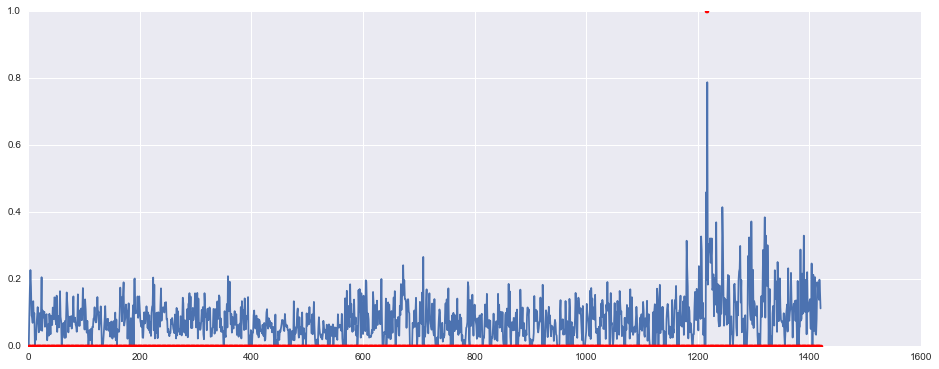

In [39]:
all_data = get_data("A1Benchmark/real_1.csv")
print(all_data.head())
data = all_data["value"].values

fig = plt.figure(figsize=(16,6))
plt.plot(all_data['timestamp'], data)
plt.plot(all_data['timestamp'], all_data['is_anomaly'],'.r')
plt.show()

s_idx = 1100
Y_train = data[:s_idx]
Y_val = data[s_idx:]

### Basic LSTM

In [95]:
# super basic test data sequence 111,222,111 etc.
# data = [1]*3 + [2]*3
# data = data*3

from pybrain.datasets import SequentialDataSet
from itertools import cycle
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure.modules import LSTMLayer
from pybrain.supervised import RPropMinusTrainer,BackpropTrainer
from sys import stdout
from __future__ import print_function

# create in sample training set
ds = SequentialDataSet(1, 1)
for sample, next_sample in zip(Y_train, cycle(Y_train[1:])):
    ds.addSample(sample, next_sample)

# create out of sample validation set
vs = SequentialDataSet(1, 1)
for sample, next_sample in zip(Y_val, cycle(Y_val[1:])):
    vs.addSample(sample, next_sample)
    
net = buildNetwork(1, 10, 1, 
                   hiddenclass=LSTMLayer, 
                   outputbias=False, 
                   recurrent=True)


trainer = RPropMinusTrainer(net, dataset=ds, 
                            etaminus=0.5, 
                            etaplus=1.2, 
                            deltamin=9.9999999999999995e-07, 
                            deltamax=5.0, 
                            delta0=0.10000000000000001)
'''
trainer = BackpropTrainer(net, dataset=ds, 
                                            learningrate=0.001, 
                                            lrdecay=1.0, 
                                            momentum=0.0, 
                                            verbose=False, 
                                            batchlearning=False, 
                                            weightdecay=0.0)
'''
train_errors = [] 
val_errors = [] 

EPOCHS_PER_CYCLE = 5
CYCLES = 20
EPOCHS = EPOCHS_PER_CYCLE * CYCLES

#trnerr,valerr = trainer.trainUntilConvergence(dataset=ds, maxEpochs=50,validationProportion=0.2)
#plt.plot(trnerr,'b',valerr,'r')
#plt.show()

for i in xrange(CYCLES):
    trainer.trainEpochs(EPOCHS_PER_CYCLE)
    train_errors.append(trainer.testOnData(ds))
    val_errors.append(trainer.testOnData(vs))
    
    epoch = (i+1) * EPOCHS_PER_CYCLE
    print("\r epoch {}/{}".format(epoch, EPOCHS),end="")
    stdout.flush()

print()
print("final training error =", train_errors[-1])
print("final validation error =", val_errors[-1])

#epoch 30/30
#final training error = 0.000993640246463
#final validation error = 0.00510549241784

#epoch 40/40
#final training error = 0.000908679491361
#final validation error = 0.00499635522852

#epoch 100/100
#final training error = 0.00088823468163
#final validation error = 0.00414170740675

 epoch 100/100
final training error = 0.00088823468163
final validation error = 0.00414170740675


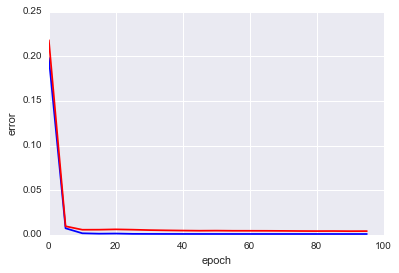

In [100]:
plt.plot(range(0, EPOCHS, EPOCHS_PER_CYCLE), train_errors, '-b')
plt.plot(range(0, EPOCHS, EPOCHS_PER_CYCLE), val_errors, '-r')
plt.xlabel('epoch')
plt.ylabel('error')
plt.show()

### Evaluation

In [97]:
# evaluate over in sample points
yf = []
for sample, target in ds.getSequenceIterator(0):
    pred = net.activate(sample)
    yf.append(pred)
print(len(Y_train),len(yf))

xf = range(len(yf))

1100 1100


In [98]:
# evaluate over valuation set
yp = []
for sample, target in vs.getSequenceIterator(0):
    pred = net.activate(sample)
    yp.append(pred)
print(len(Y_val),len(yp))

xp = np.arange(len(yf),len(yf)+len(yp))

320 320


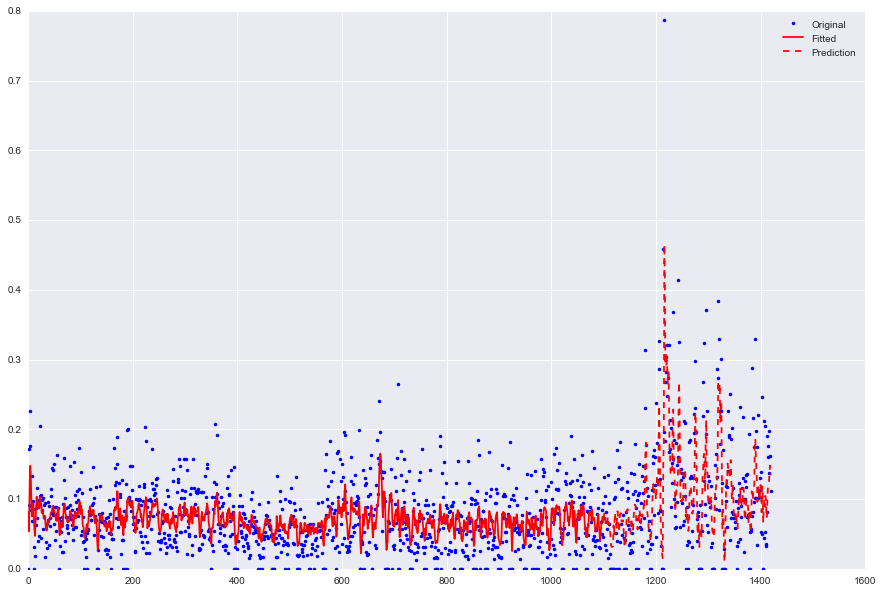

R^2: 0.407346495567
MSE: 0.0128618974928


In [99]:
# how does it look?
plt.figure(figsize=(15,10))
plt.plot(range(len(data)), data, '.b') #original
plt.plot(xf, yf, '-r') # in sample fit
plt.plot(xp,yp, '--r') # out of sample
plt.legend( ('Original','Fitted','Prediction') ) 
plt.show()

temp = r2(Y_train,yf)
print("R^2: {}".format(temp))

# out of sample MSE
temp = np.mean((yp - Y_val) ** 2)
print("MSE: {}".format(temp))